In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import vision

### Getting the data

In [3]:
path = vision.Path('data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data')

In [11]:
#!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}

In [12]:
#!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}
#!rm {path}/train-jpg.tar.7z

In [6]:
#!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}

In [7]:
#!7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#!rm {path}/test-jpg.tar.7z

In [15]:
#!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

In [16]:
#!unzip -q -o {path}/train_v2.csv.zip -d {path}
#!rm {path}/train_v2.csv.zip

In [22]:
path.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/.DS_Store')]

In [4]:
import random

def shrink_test_set(n=1000):
    # Use only N random images for testing, remove everything else
    test_img_paths = random.sample((path/'test-jpg').ls(), n)
    for img_path in (path/'test-jpg').ls():
        if img_path not in test_img_paths:
            img_path.unlink()
            
#shrink_test_set()

### Data exploration

In [4]:
# Read labels
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


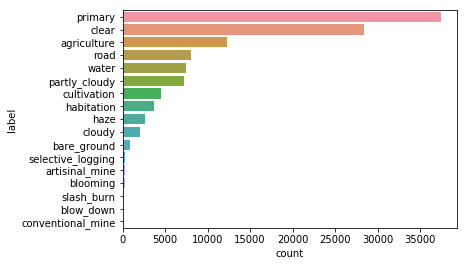

In [76]:
import seaborn as sns
from collections import Counter

# Plot count distribution of labels
def plot_dist(lst_of_lsts):
    lst_flat = [l for lst in lst_of_lsts for l in lst]
    df = pd.DataFrame(Counter(lst_flat).most_common(), columns=['label', 'count'])
    ax = sns.barplot(x='count', y='label', data=df)
    ax.set_xlabel('count')
    
lst_of_lsts = df['tags'].apply(lambda x: x.split(' ')).tolist()
plot_dist(lst_of_lsts)

In [67]:
%%time

# Build (relative) co-occurrence matrix of labels
def build_coo_matrix(lst_of_lsts):
    lst_flat = [l for lst in lst_of_lsts for l in lst]
    counter = Counter(lst_flat)
    distinct = set(lst_flat)
    df = pd.DataFrame(0, columns=distinct, index=distinct)
    for lst in lst_of_lsts:
        for i in range(len(lst)):
            a = lst[i]
            for j in range(i, len(lst)):
                b = lst[j]
                if a != b:
                    df.loc[a, b] += 1
                    df.loc[b, a] += 1
    for l in distinct:
        df.loc[l] /= counter[l]
    np.fill_diagonal(df.values, np.nan)
    return df

coo_df = build_coo_matrix(lst_of_lsts)

CPU times: user 1min 3s, sys: 401 ms, total: 1min 3s
Wall time: 1min 3s


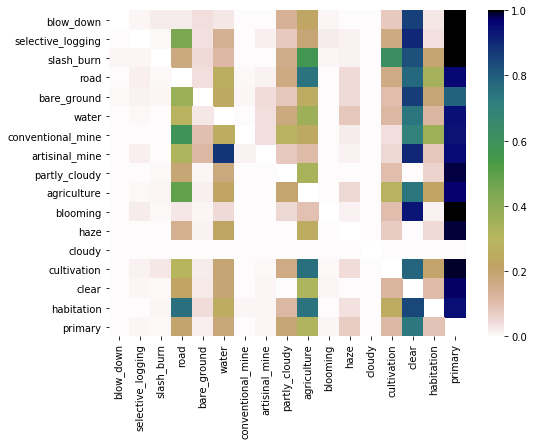

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(coo_df, ax=ax, cmap=plt.cm.gist_earth_r)

In [105]:
import cv2

# Import a subset of images, normalize and stack them into a tensor
def get_img_mat(img_paths):
    all_imgs = []
    
    for img_path in img_paths:
        img = plt.imread(img_path)
        img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
        img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
        img = img.reshape(1, -1)
        all_imgs.append(img)
        
    img_mat = np.vstack(all_imgs)
    return img_mat

img_paths = random.sample((path/'train-jpg').ls(), 500)
img_mat = get_img_mat(img_paths)
img_mat.shape

(500, 40000)

In [110]:
from sklearn.manifold import TSNE

# Cluster images by their native representation (pixel intensities)
tsne = TSNE(
    n_components=2,
    init='random',
    random_state=42,
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.378s...
[t-SNE] Computed neighbors for 500 samples in 15.817s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2.269228
[t-SNE] Computed conditional probabilities in 0.016s
[t-SNE] Iteration 50: error = 74.1201096, gradient norm = 0.4368798 (50 iterations in 0.185s)
[t-SNE] Iteration 100: error = 77.0585480, gradient norm = 0.4185413 (50 iterations in 0.179s)
[t-SNE] Iteration 150: error = 78.0700912, gradient norm = 0.4224377 (50 iterations in 0.175s)
[t-SNE] Iteration 200: error = 78.4298630, gradient norm = 0.3928973 (50 iterations in 0.182s)
[t-SNE] Iteration 250: error = 79.1689758, gradient norm = 0.3695485 (50 iterations in 0.181s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.168976
[t-SNE] Iteration 300: error = 0.9336667, gradient norm = 0.0038811 (50 iterations in 0.172s)
[t-SNE] Iteration 350: error = 0.8640597, gradient norm = 0.0012030 

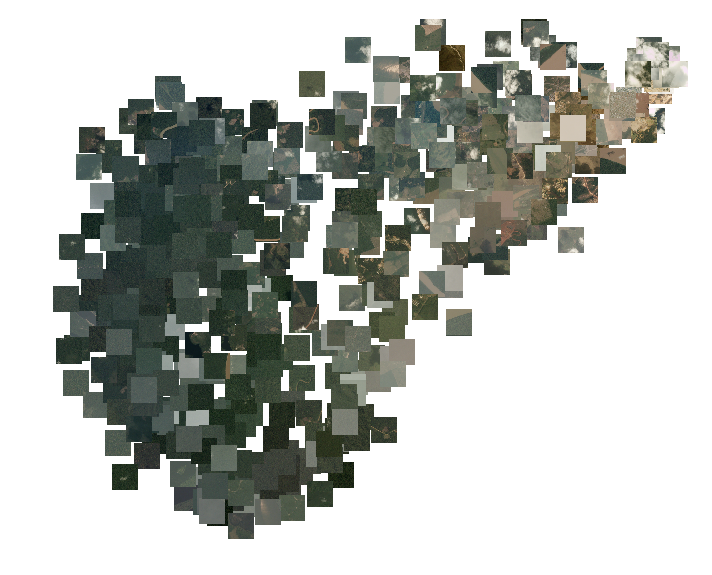

In [111]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Shows a 2D embedding but with the actual images overlaid
def imscatter(tsne, img_paths, zoom=0.1):
    x, y = tsne[:,0], tsne[:,1]
    imgs = [plt.imread(img_path) for img_path in img_paths]
    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    images = [OffsetImage(img, zoom=zoom) for img in imgs]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    ax.axis('off')
    plt.show()

imscatter(tsne, img_paths)

### Multi-label classification

In [25]:
tfms = vision.get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [26]:
np.random.seed(42)
src = (vision.ImageItemList.from_csv(path, csv_name='train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [10]:
# Separate from previous blocks to re-run later for bigger size
data = (src.transform(tfms, size=128)
        .databunch()
        .normalize(vision.imagenet_stats))

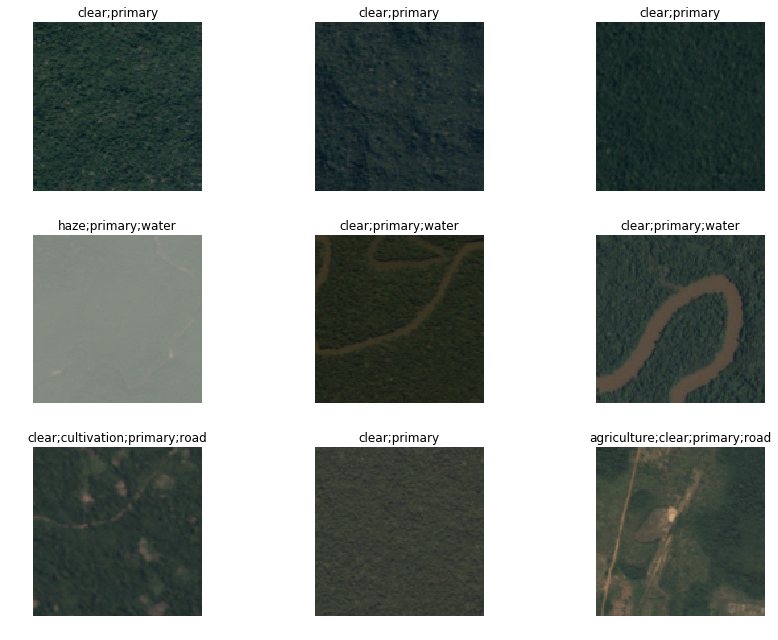

In [15]:
data.show_batch(rows=3, figsize=(12,9))

In [7]:
arch = vision.models.resnet50

In [11]:
# Prediction bigger than a threshold becomes true
acc_02 = vision.partial(vision.accuracy_thresh, thresh=0.2)
# F1 score
f_score = vision.partial(vision.fbeta, thresh=0.2)
learn = vision.create_cnn(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


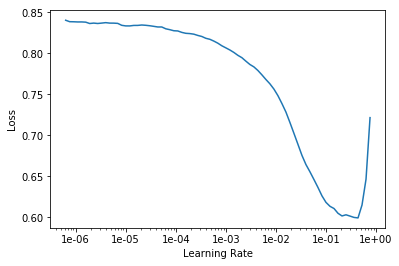

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.121001,0.122037,0.937928,0.890321
2,0.112585,0.107372,0.942281,0.903020
3,0.107948,0.101333,0.945049,0.908778
4,0.094501,0.087555,0.956465,0.924194
5,0.089162,0.085020,0.957236,0.926705


In [20]:
learn.save('stage-1-rn50')

In [13]:
learn.load('stage-1-rn50');

In [21]:
# Fine-tuning
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


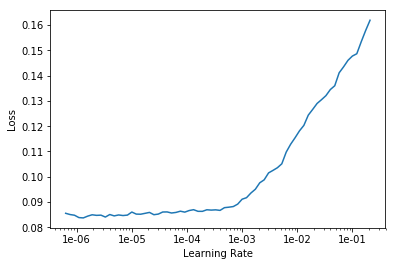

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.091772,0.085637,0.958747,0.926595
2,0.093573,0.084974,0.957708,0.927230
3,0.088507,0.084307,0.957337,0.927258
4,0.087725,0.084456,0.958464,0.927076
5,0.084592,0.083944,0.957156,0.927633


In [24]:
learn.save('stage-2-rn50')

In [20]:
learn.load('stage-2-rn50');

In [21]:
# Increase image size for better generalization
data = (src.transform(tfms, size=256)
        .databunch(bs=32)
        .normalize(vision.imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [22]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


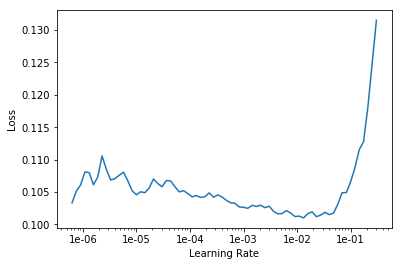

In [18]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.092512,0.088157,0.958733,0.925716
2,0.093181,0.085286,0.956807,0.926557
3,0.090973,0.084986,0.959060,0.926956


In [24]:
learn.save('stage-1-256-rn50')

In [26]:
learn.load('stage-1-256-rn50');

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


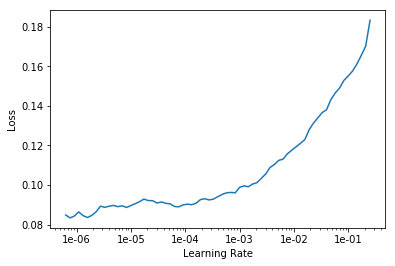

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087724,0.085253,0.958929,0.926506
2,0.086465,0.084441,0.959743,0.926849
3,0.086552,0.083977,0.958435,0.927223


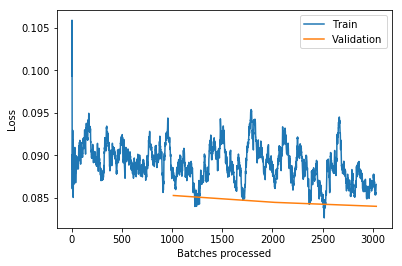

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-2-256-rn50')

In [32]:
# Export inference learner
learn.export('Resnet50_256.pkl')

### Inference learner

In [36]:
learn = vision.load_learner(path, test=vision.ImageItemList.from_folder(path/'test-jpg'))

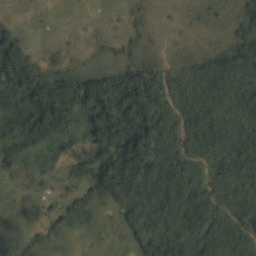

In [11]:
img = learn.data.test_ds[1][0]; img

In [12]:
learn.predict(img, thresh=0.2)

(MultiCategory agriculture;clear;cultivation;habitation;primary;road,
 tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.]),
 tensor([9.8097e-01, 4.6050e-06, 2.3099e-03, 6.1658e-05, 7.0370e-05, 9.9809e-01,
         9.8640e-06, 1.3753e-05, 2.6119e-01, 4.5677e-01, 9.3498e-04, 6.4913e-04,
         9.9870e-01, 8.8329e-01, 7.6543e-04, 2.6435e-03, 1.8607e-01]))

In [9]:
preds, _ = learn.get_preds(ds_type=vision.DatasetType.Test)

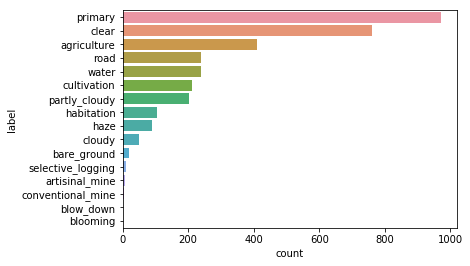

In [63]:
# The distribution must be similar to that of train
lst_of_lsts = []
for pred in preds:
    lst_of_lsts.append(np.array(src.classes)[np.where(pred > 0.2)])
    
plot_dist(lst_of_lsts)